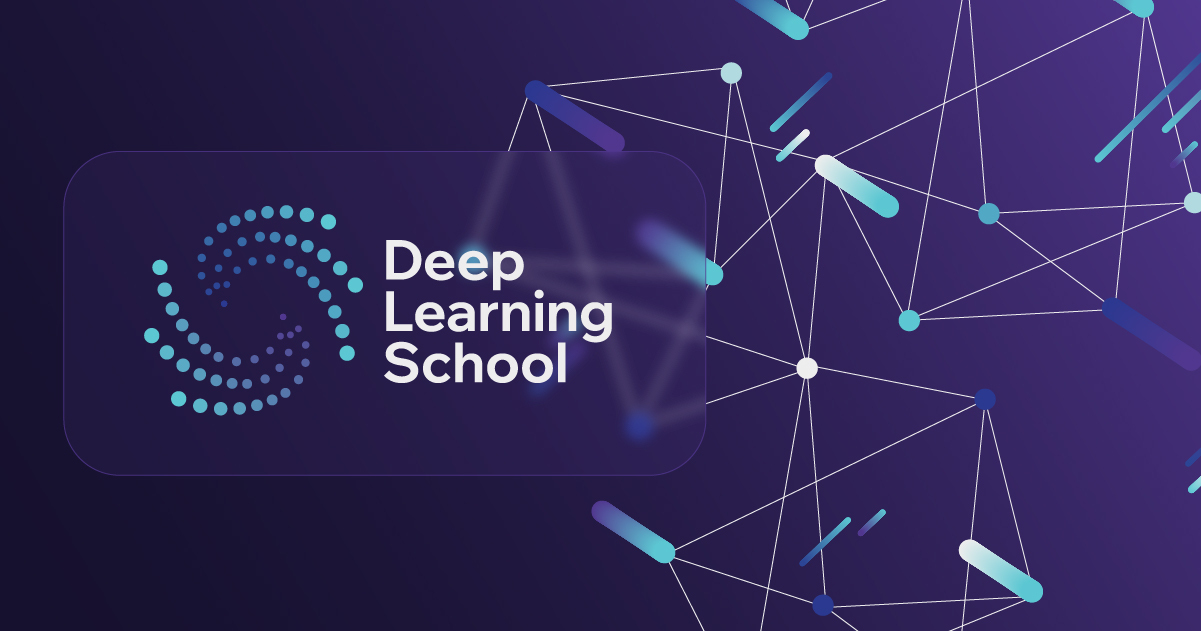

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

In [2]:
!pip install --no-cache-dir torchmetrics;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 233.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 272.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 291.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 195.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 166.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 170.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 189.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 208.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 209.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    U

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [5]
  * backbone[1],
  * Neck [3],
  * Head [1]
* Label assignment [2]:
  * TAL [2]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.15 mAP [1]
  * 0.3 mAP  [2]
  * 0.6 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import albumentations as A
import timm
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

import io
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.ops import nms, box_iou, sigmoid_focal_loss, generalized_box_iou_loss

from typing import List
from tqdm.auto import tqdm
from functools import partial
from torchmetrics.detection import MeanAveragePrecision
import cv2

### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [2]:
class_to_color = {
    1: (89, 161, 197),
    2: (204, 79, 135),
    3: (125, 216, 93),
    4: (175, 203, 33),
}

class_to_name = {
    1 : "enemy",
    2 : "enemy-head",
    3 : "friendly",
    4 : "friendly-head"
}

splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Создаем датасет для предобработки данных

In [3]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df_objects = pd.json_normalize(dataframe['objects'])[["bbox", "category"]]
        df_images = pd.json_normalize(dataframe['image'])[["bytes"]]
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        labels: List[int] Набор классов для каждого ббокса,
        boxes: List[List[int]] Набор ббоксов в формате (x_min, y_min, w, h).
        """
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row["bytes"]))
        image = np.array(image)

        target = {}
        target["image_id"] = row["image_id"]

        labels = [row["category"]] if isinstance(row["category"], int) else row['category']
        # Вычитаем единицу чтобы классы начинались с нуля
        labels = [label - 1 for label in labels]
        boxes = row['bbox'].tolist()

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        target['boxes'] = torch.tensor(np.array(boxes), dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        return image, target

def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

Тут можно написать любые аугментации

Min bboxes per image: 0
Max bboxes per image: 6
Mean bboxes per image: 1.84


Number of object per class:
enemy-head : 331
enemy : 387
friendly-head : 37
friendly : 93

Mean bbox size per class:
enemy : [117.48837 205.58656]
enemy-head : [46.95468  49.123867]
friendly : [113.91398 213.46237]
friendly-head : [61.45946 57.62162]





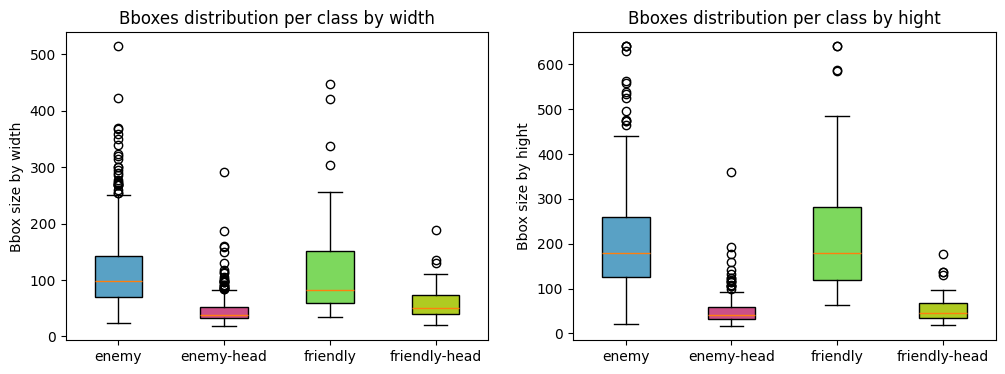

In [4]:
def part_info(df):
    """ Считаем статистики по датасету и рисуем распределение размеров ббоксов по классам. """
    df = pd.json_normalize(df['objects'])[["bbox", "category"]]
    obj_per_img = df['bbox'].apply(lambda obj: len(obj))
    print(f"Min bboxes per image: {obj_per_img.min()}")
    print(f"Max bboxes per image: {obj_per_img.max()}")
    print(f"Mean bboxes per image: {obj_per_img.mean():.3}")

    all_categories = df['category'].apply(lambda obj: obj).tolist()
    counter = Counter(np.concatenate(all_categories))
    msg = [f"{class_to_name[key]} : {value}" for key, value in counter.items()]
    print("\n\nNumber of object per class:\n" + "\n".join(msg))

    bboxes = defaultdict(list)
    for _, row in df.iterrows():
        for bb, cls in zip(row['bbox'], row['category']):
            bboxes[cls].append(list(bb[2:]))
    bboxes = dict(sorted(bboxes.items()))
    print("\nMean bbox size per class:")
    for cls, boxes_list in bboxes.items():
        print(f"{class_to_name[cls]} : {np.mean(boxes_list, axis=0)}")

    print("\n\n")
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    x_boxes = [np.array(val)[:, 0] for val in bboxes.values()]
    y_boxes = [np.array(val)[:, 1] for val in bboxes.values()]
    labels = [class_to_name[cls] for cls in class_to_name.keys()]
    colors = [class_to_color[cls] for cls in class_to_color.keys()]
    for ax, box, direction in zip(axes, [x_boxes, y_boxes], ["width", "hight"]):
        bplot = ax.boxplot(box, patch_artist=True, tick_labels=labels)
        for patch, color in zip(bplot["boxes"], colors):
            patch.set_facecolor(np.array(color) / 255)
        ax.set_ylabel(f"Bbox size by {direction}")
        ax.set_title(f"Bboxes distribution per class by {direction}")

box_sizes = part_info(df_train)

In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        # Добавляй сюда свои аугментации при необходимости!
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Раскомментируй, если аугментации изменяют ббоксы.
    # Не забудь указать верный формат для ббоксов.
    # bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

Не забываем инициализировать наш датасет

In [6]:
train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)

## Переделываем модель [5 баллов]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать.



### Backbone [1 балл]

В лекции мы заморозили все слои у модели. Вам нужно написать бекбоун с возможностью разморозки __k__ последних слоев или блоков (на ваш выбор).

In [11]:
class Backbone(nn.Module):
    def __init__(self, model_name, out_indices, unfreeze_last):
        super().__init__()

        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=out_indices)

        for param in self.backbone.parameters():
            param.requires_grad = False

        for block in self.backbone.blocks[:len(self.backbone.blocks)-unfreeze_last-1:-1]:
            for block_param in block.parameters():
                block_param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

### NECK [3 балла]

Вам предлагается на выбор написать одну из двух шей:

#### Feature Pyramid Network [2 балла]

Знакомая из лекции архитектура шеи:

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

#### Path Aggregation Network [3 балла]

Другая архитектура немного сложнее. Она содержит не только top-down путь, но ещё bottom-up путь:

<center><img src="https://i.ibb.co/k68BWBGv/path-aggregation-network.png" width="500"/></center>

* [Path Aggregation Network for Instance Segmentation](https://arxiv.org/abs/1803.01534)

Подробное описание архитектуры можно найти в секции 3 (Framework). Реализовывать adaptive feature pooling не нужно.


__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели,
* Также, можно добавить доп конволюцию (3х3 с паддингом) у каждого выхода шеи.

In [12]:
class FPN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FPN, self).__init__()
        # Lateral connections
        self.lat_conns = nn.ModuleList([ nn.Conv2d(channel, out_channels, 1) for channel in in_channels])
        self.activation = nn.ReLU(inplace=True)

        # Top-down layers
        self.topdown = nn.Conv2d(out_channels, out_channels, 3, padding=1)

    def forward(self, input):

        # Top-down pathway with lateral connections
        results = []
        for i in range(len(input)):
            c = input[::-1][i]
            lat_conn = self.lat_conns[i]
            if i==0:
                p = self.activation(lat_conn(c))
            else:
                prev_p = results[-1]
                p = self.activation(self.topdown(lat_conn(c) + F.interpolate(prev_p, scale_factor=2)))

            results.append(p)

        return results

### Head [1 балл]

В качестве шеи можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center><img src="https://i.ibb.co/BVtBR2R3/Decoupled-head.jpg"/></center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса!

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

In [13]:
class Head(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1x1 = nn.Conv2d(in_channels, 256, kernel_size=1)
        self.conv3x3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.cls_head = nn.Conv2d(256, num_anchors * num_classes, kernel_size=1)
        self.reg_head = nn.Conv2d(256, num_anchors * 4, kernel_size=1)
        self.num_classes = num_classes

    def forward(self, x: List[torch.Tensor]):
        results = []
        for input in x:
            input = self.activation(self.conv1x1(input))
            input = self.activation(self.conv3x3(input))
            input = self.activation(self.conv3x3(input))

            cls_res = self.cls_head(input)
            reg_res = self.reg_head(input)
            results.append((cls_res,reg_res))
        return results

### Detector

Теперь можно снова реализовать класс детектора с учетом всех частей выше!

In [14]:
class Detector(nn.Module):
    def __init__(self,
                 backbone_model_name="efficientnet_b0",
                 backbone_out_indices = (-1, -2, -3),
                 unfreeze_last_backbone_layers = 2,
                 neck_n_channels=256,
                 num_classes=4,
                 anchor_sizes=(32, 64, 128),
                 anchor_ratios=(0.5, 1.0, 2.0),
                 input_size=(640, 640),
                ) -> None:
        super(Detector, self).__init__()
        self.backbone = Backbone(model_name=backbone_model_name,
                                 out_indices=backbone_out_indices,
                                 unfreeze_last = unfreeze_last_backbone_layers,
                                )

        backbone_out_channels = self.backbone.backbone.feature_info.channels()

        self.neck = FPN(in_channels = backbone_out_channels,
                        out_channels = neck_n_channels
                       )

        reductions = self.backbone.backbone.feature_info.reduction(backbone_out_indices)
        grid_sizes = [[input_size[0] // reduction, input_size[1] // reduction] for reduction in reductions ]

        anchor_generator = AnchorGenerator(sizes=[anchor_sizes for i in range(len(backbone_out_indices))], aspect_ratios=[anchor_ratios for i in range(len(backbone_out_indices))] )

        num_anchors = len(anchor_sizes) * len(anchor_ratios)
        anchors = anchor_generator.grid_anchors(grid_sizes, strides=[ [reduction,reduction] for reduction in reductions])

        self.head = Head(num_anchors=num_anchors,
                         num_classes=num_classes,
                         in_channels=neck_n_channels
                        )

        self.anchors = anchors
        self.num_classes = num_classes

    def forward(self, x):
        features = self.backbone(x)
        neck_features = self.neck(features)
        head_features = self.head(neck_features)

        # Преобразуем сырые выходы модели в формат, в котором будет удобно считать лосс
        # cls_logits - [N, NUM_ANCHORS * NUM_CLASSES, W, H]
        # bbox_preds - [N, NUM_ANCHORS * 4, W, H]
        N = x.shape[0]
        result = []

        for cls_logits, bbox_preds in head_features:
            cls_logits = cls_logits.permute(0, 2, 3, 1).contiguous()
            cls_logits = cls_logits.view(N, -1, self.head.num_classes) # [N, NUM_ANCHORS * W * H, NUM_CLASSES]
            bbox_preds = bbox_preds.permute(0, 2, 3, 1).contiguous()
            bbox_preds = bbox_preds.view(N, -1, 4) # [N, NUM_ANCHORS * W * H, 4]

            result.append((bbox_preds, cls_logits))



        if self.training:
            # В процессе тренировки возвращаем просто смещения и логиты
            return result

        # Если мы делаем предсказание, сразу считаем итоговый ббокс и вероятности
        # Модель предсказывает ббоксы в формате (x_min, y_min, w, h)
        pred_result = []
        for idx, r in enumerate(result):
            bbox_offsets, cls_logits = result[idx]
            anchor = self.anchors[idx]
            bboxes = decode_bboxes(bbox_offsets, anchor)
            cls_probs = torch.softmax(cls_logits, dim=-1)
            pred_result.append((bboxes, cls_probs))

        return pred_result

## Label assignment [2]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [15]:
def decode_bboxes(bbox_offsets, anchors):
        """Используя предсказанные смещения, считаем предсказанные ббоксы по формулам из YOLOv3.

        Боксы возвращаются в формате (x_min, y_min, w, h).
        """
        anchor_centers = (anchors[:, :2] + anchors[:, 2:]) / 2
        anchor_centers = anchor_centers.to(bbox_offsets.device)
        anchor_sizes = (anchors[:, 2:] - anchors[:, :2])
        anchor_sizes = anchor_sizes.to(bbox_offsets.device)
        tx = bbox_offsets[:, :, 0]
        ty = bbox_offsets[:, :, 1]
        tw = torch.clamp(bbox_offsets[:, :, 2], min=-4.0, max=2.0)
        th = torch.clamp(bbox_offsets[:, :, 3], min=-4.0, max=2.0)

        center_x = anchor_centers[:, 0] + torch.sigmoid(tx) * anchor_sizes[:, 0]
        center_y = anchor_centers[:, 1] + torch.sigmoid(ty) * anchor_sizes[:, 1]

        w = torch.exp(tw) * anchor_sizes[:, 0]
        h = torch.exp(th) * anchor_sizes[:, 1]

        x_min = center_x - w / 2
        y_min = center_y - h / 2
        return torch.stack([x_min, y_min, w, h], dim=-1)

In [16]:
def assign_labels(outputs, gt_boxes, gt_labels, anchor_list, batch_size, num_classes, ALPHA=6, BETA=1, k_predictions=5):
    labels = []
    inds = []

    gt_count = gt_boxes.shape[0]
    if gt_count == 0:
        return labels, inds

    gt_xyxy = gt_boxes.clone()
    gt_xyxy[:, 2:] += gt_xyxy[:, :2]  # convert (x, y, w, h) → (x1, y1, x2, y2)

    for output_idx, (bbox_offsets, cls_score_logits) in enumerate(outputs):
        anchors = anchor_list[output_idx]
        num_boxes = anchors.size(0)

        # Decode predicted boxes and convert to (x1, y1, x2, y2)
        pred_bboxes = decode_bboxes(bbox_offsets, anchors)
        pred_bboxes_xyxy = pred_bboxes.clone()
        pred_bboxes_xyxy[:, :, 2:] += pred_bboxes_xyxy[:, :, :2]

        ious = box_iou(pred_bboxes_xyxy[0], gt_xyxy)  # (N, M)
        cls_scores = cls_score_logits.sigmoid()[0]    # (N, C)

        cls_scores_for_gt = cls_scores[:, gt_labels]  # (N, M)
        tiou_scores = (cls_scores_for_gt ** ALPHA) * (ious ** BETA)

        topk_scores, topk_indices = torch.topk(tiou_scores, k_predictions, dim=0)  # (K, M)

        assigned_labels = torch.zeros(num_boxes, dtype=torch.long, device=device)
        assigned_gt = torch.full((num_boxes,), -1, dtype=torch.long, device=device)

        # Assign top-k anchors to each GT box
        for gt_idx in range(gt_count):
            anchor_ids = topk_indices[:, gt_idx]
            assigned_labels[anchor_ids] = 1
            assigned_gt[anchor_ids] = gt_idx

        labels.append(assigned_labels)
        inds.append(assigned_gt)

    return labels, inds


In [17]:
def calculate_loss(
    assigned_labels,
    assigned_gt_indices,
    cls_scores,
    reg_preds,
    anchors,
    gt_boxes,
    gt_labels,
    lambda_reg=5.0
):
    """
    Calculates the total loss based on TOOD label assignment.

    Args:
        assigned_labels: (N,) Tensor with 0 for background, 1 for foreground.
        assigned_gt_indices: (N,) Tensor with GT index for each positive anchor, -1 for background.
        cls_scores: (1, N, num_classes) Classification logits.
        reg_preds: (1, N, 4) Regression predictions (encoded).
        anchors: (N, 4) Anchor box coordinates.
        gt_boxes: (M, 4) Ground truth boxes.
        gt_labels: (M,) Ground truth labels.

    Returns:
        total_loss: Scalar tensor representing the total loss.
    """

    batch_size, num_anchors, num_classes = cls_scores.shape
    num_positives = assigned_labels.sum().item()

    # One-hot encode classification targets (skip background class 0)
    target_labels = F.one_hot(assigned_labels, num_classes=num_classes + 1)[:, 1:]  # (N, num_classes)

    # Decode predicted boxes
    decoded_boxes = decode_bboxes(reg_preds, anchors).squeeze()  # (N, 4)
    decoded_boxes[:, 2:] += decoded_boxes[:, :2]  # Convert to (x1, y1, x2, y2)

    gt_boxes_xyxy = gt_boxes.clone()
    gt_boxes_xyxy[:, 2:] += gt_boxes_xyxy[:, :2]

    # --- Classification Loss ---
    cls_loss = sigmoid_focal_loss(
        cls_scores.squeeze(0), target_labels.float(), reduction='sum'
    )
    cls_loss /= max(num_positives, 1)  # Avoid division by zero

    # --- Regression Loss ---
    pos_mask = assigned_labels > 0

    if pos_mask.any():
        pred_pos_boxes = decoded_boxes[pos_mask]
        gt_pos_indices = assigned_gt_indices[pos_mask]
        target_pos_boxes = gt_boxes_xyxy[gt_pos_indices]

        reg_loss = generalized_box_iou_loss(
            pred_pos_boxes, target_pos_boxes, reduction='sum'
        )
        reg_loss /= max(num_positives, 1)
    else:
        reg_loss = torch.tensor(0.0, device=cls_scores.device)

    # --- Total Loss ---
    total_loss = cls_loss + lambda_reg * reg_loss
    return total_loss


In [18]:
class Runner:
    """ Базовый класс для обучения и валидации модели.

    Параметры
    ---------
    model : torch модель, которая будет обучаться.
    compute_loss : экземпляр класса ComputeLoss (или другого с реализованным методом __call__).
    optimizer : torch optimizer
    train_dataloader : torch dataloader семплирующий данные для обучения модели.
    assign_target_method : callable, который решает задачу сопоставления якорей и таргета (например, assign_target)
    deivce : девайс на котором будет происходить обучения, по дефолту "cpu"
    scheduler : torch scheduler
    val_dataloader : torch dataloader загружающий валидационные данные.
    score_threshold : При расчете метрики на валидации, все предсказания,
        с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.
    """
    def __init__(self, model,
                 compute_loss,
                 optimizer, train_dataloader, assign_target_method, device=None,
                 scheduler=None,
                 val_dataloader=None, val_every=5, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.assign_target_method = assign_target_method
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        # Валидационные параметры
        self.val_dataloader = val_dataloader
        self.val_every = val_every
        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls

        # Вспомогательные массивы
        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []

    def _run_train_epoch(self, dataloader, verbose=True):
        """ Обучить модель одну эпоху на данных из `dataloader` """
        self.model.train()
        batch_loss = []
        for images, targets in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            outputs = self.model(images)

            anchor_list = self.model.anchors
            accum_loss = 0.0
            batch_size = images.shape[0]
            for ix in range(batch_size):
                gt_boxes = targets[ix]['boxes'].to(self.device)
                gt_labels = targets[ix]['labels'].to(self.device)

                image_outputs = [ [detector_res[ix:ix+1,:] for detector_res in output]  for output in outputs] # tuple(tuple(bbox_offsets, cls_logits))

                # assigned_labels - list(single_feature_map_assigned_labels)

                assigned_labels, assigned_inds  = self.assign_target_method( outputs=image_outputs,
                                                             gt_boxes = gt_boxes,
                                                             gt_labels = gt_labels,
                                                             anchor_list = anchor_list,
                                                             batch_size = batch_size,
                                                             num_classes=model.num_classes
                                                            )
                for i in range(len(image_outputs)):
                    if len(assigned_labels) == 0:
                        continue
                    anchors = anchor_list[i]
                    single_feature_map_assigned_labels = assigned_labels[i]
                    single_featur_map_assigned_inds = assigned_inds[i]
                    bbox_offsets, cls_logits = image_outputs[i]
                    loss = self.compute_loss(single_feature_map_assigned_labels,
                                             single_featur_map_assigned_inds,
                                             cls_logits,
                                             bbox_offsets, anchors, gt_boxes, gt_labels)
                    accum_loss += loss
            accum_loss = accum_loss / batch_size
            if accum_loss != 0.0:
                batch_loss.append(accum_loss.cpu().detach().item())

                # Делаем шаг оптимизатора после расчета лосса для всех элементов батча
                self.optimizer.zero_grad()
                accum_loss.backward()
                self.optimizer.step()
                # Обновляем описание tqdm бара усредненным значением лосса за предыдущй батч
                if verbose:
                    pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4}")
        return batch_loss

    def train(self, num_epochs=10, verbose=True):
        """ Обучаем модель заданное количество эпох. """
        val_desc = ""
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))

            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                val_metric = self.validate()
                self.val_metric.append(val_metric)
                val_desc = f" Val {val_metric:.8}"

            # # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.4}" + val_desc)
            # Делаем шаг scheduler'a если он был передан
            if self.scheduler is not None:
                self.scheduler.step()



    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue")
        ax[0].plot(np.arange(1, len(self.batch_loss)+1, len(self.train_dataloader)), self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss")
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Iterations")
        ax[0].set_ylabel("Loss")
        if self.val_metric:
            ax[1].plot(np.arange(self.val_every, len(self.batch_loss)+1, len(self.val_dataloader) * self.val_every),
                       np.array(self.val_metric) * 100, color="tab:green", label="Validation mAP")
            ax[1].grid()
            ax[1].set_title("Valiation mAP")
            ax[1].set_xlabel("Number of Iterations")
            ax[1].set_ylabel("mAP (%)")
        plt.legend()
        plt.show()


    @torch.no_grad()
    def validate(self, dataloader=None):
        """ Метод для валидации модели. Если dataloader не передан, будет использоваться self.val_dataloder.
        Возвращает mAP (0.5 ... 0.95).
        """
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader
        # Считаем метрику mAP с помощью функции из torchmetrics
        metric = MeanAveragePrecision(box_format="xywh", iou_type="bbox")
        for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
            images = images.to(self.device)
            outputs = self.model(images)

            cls_prob_list = []
            bbox_preds_list = []

            for bbox_offsets, cls_logits in outputs:
                bbox_preds_list.append(bbox_offsets)
                cls_prob_list.append(cls_logits)

            predictions = filter_predictions_for_map(cls_prob_list, bbox_preds_list)
            predictions = [{k: v.to(device) for k, v in p.items()} for p in predictions]
            targets = [{k: torch.Tensor(v).to(device) for k, v in t.items()} for t in targets]
            metric.update(predictions, targets)
        return metric.compute()["map"].item()

In [19]:
from torchvision.ops import batched_nms

def filter_predictions_for_map(
    cls_prob_list,
    bbox_preds_list,
    confidence_threshold=0.31,
    nms_iou_threshold=0.8,
    max_boxes=10
):
    """
    Filters predictions using batched NMS across all classes.

    Args:
        cls_prob_list (List[Tensor]): List of (B, N, C) classification probabilities per FPN level.
        bbox_preds_list (List[Tensor]): List of (B, N, 4) bbox predictions per FPN level.
        confidence_threshold (float): Minimum score to keep a box.
        nms_iou_threshold (float): IoU threshold for NMS.
        max_boxes (int): Max number of total boxes to keep per image after NMS.

    Returns:
        List[Dict]: Filtered predictions per image with keys: boxes, scores, labels.
    """
    filtered_results = []
    num_images = cls_prob_list[0].shape[0]
    num_levels = len(cls_prob_list)

    for img_idx in range(num_images):
        all_scores = []
        all_boxes = []
        all_labels = []

        for lvl in range(num_levels):
            cls_probs = cls_prob_list[lvl][img_idx]      # (N, C)
            bbox_preds = bbox_preds_list[lvl][img_idx]   # (N, 4)

            scores, labels = torch.max(cls_probs, dim=1)  # Best class per anchor

            keep = scores > confidence_threshold
            if keep.sum() == 0:
                continue

            all_scores.append(scores[keep])
            all_boxes.append(bbox_preds[keep])
            all_labels.append(labels[keep])

        if not all_boxes:
            filtered_results.append({
                "boxes": torch.empty(0, 4, device=device),
                "scores": torch.empty(0, device=device),
                "labels": torch.empty(0, dtype=torch.int64, device=device)
            })
            continue

        boxes = torch.cat(all_boxes, dim=0)
        scores = torch.cat(all_scores, dim=0)
        labels = torch.cat(all_labels, dim=0)

        # Convert to (x1, y1, x2, y2)
        boxes_xyxy = boxes.clone()
        boxes_xyxy[:, 2:] += boxes_xyxy[:, :2]

        keep = batched_nms(boxes_xyxy, scores, labels, nms_iou_threshold)

        if len(keep) > max_boxes:
            keep = keep[:max_boxes]

        filtered_results.append({
            "boxes": boxes[keep].to(device),
            "scores": scores[keep].to(device),
            "labels": labels[keep].to(device)
        })

    return filtered_results


In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=9, shuffle=False, collate_fn=collate_fn)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3

model = Detector(num_classes=4, anchor_sizes=(30, 50, 140, 300), anchor_ratios=(0.5, 1, 1.6, 2)).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-5)

smooth_l1_loss = nn.SmoothL1Loss()
bce_loss = nn.BCEWithLogitsLoss()
compute_loss = calculate_loss

runner = Runner(model,
                compute_loss,
                optimizer, train_dataloader, assign_labels, device=device,
                 scheduler=scheduler,
                 val_dataloader=test_dataloader,
                val_every=1)

num_epochs = 1

In [22]:
runner.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/462 [00:00<?, ?it/s]

Running validation:   0%|          | 0/16 [00:00<?, ?it/s]

ValueError: x and y must have same first dimension, but have shapes (24,) and (1,)

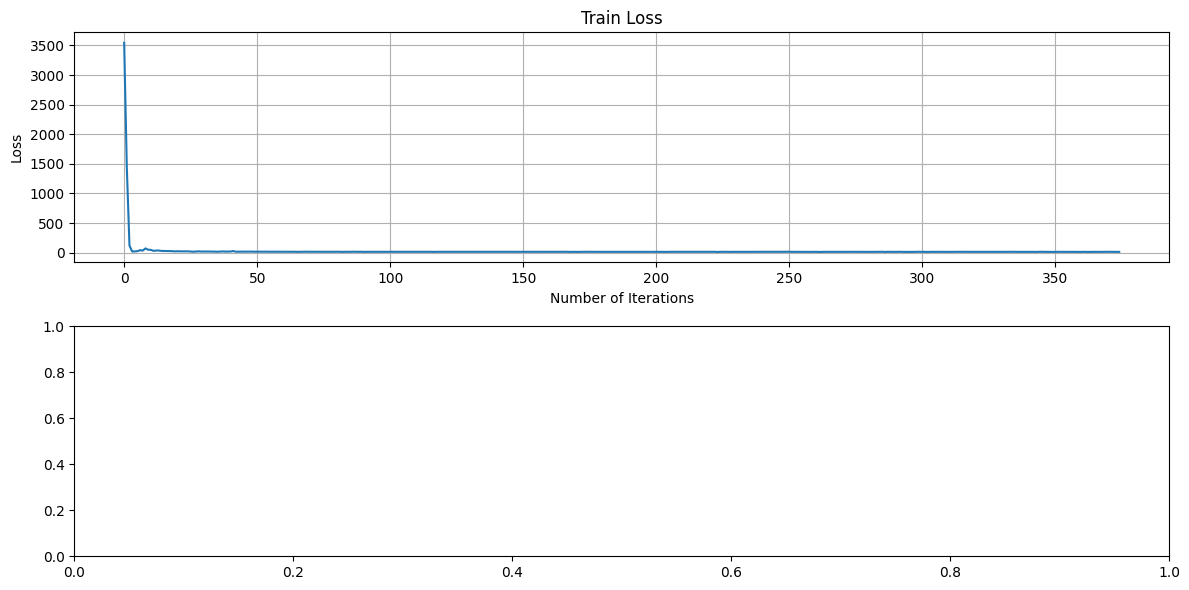

In [23]:
runner.plot_loss()

### DIoU [1]

Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>

Для его реализации разобъем задачу на части:

**1. Реализуем IoU:**

Пусть даны координаты для предсказанного ($B^p$) и истинного ($B^g$) ббоксов в формате XYXY или VOC PASCAL (левый верхний и правый нижний углы):

$B^p=(x^p_1, y^p_1, x^p_2, y^p_2)$, $B^g=(x^g_1, y^g_1, x^g_2, y^g_2)$, тогда алгоритм расчета будет следующий:

    1. Найдем площади обоих ббоксов:
$$ A^p = (x^p_2 - x^p_1) * (y^p_2 - y^p_1) $$
$$ A^g = (x^g_2 - x^g_1) * (y^g_2 - y^g_1) $$

    2. Посчитаем пересечение между ббоксами:

Тут мы предлагаем вам подумать как в общем виде можно расчитать размеры ббокса, который будет являться пересечением $B^p$ и $B^g$, а затем посчитать его площадь:

$$x^I_1 = \qquad \qquad y^I_1 = $$
$$x^I_2 = \qquad \qquad y^I_2 = $$

В общем виде, площать будет записываться следующим образом:

Если $x^I_2 > x^I_1$ & $y^I_2 > y^I_1$, тогда:

$$I = (x^I_2 - x^I_1) * (y^I_2 - y^I_1)$$

Иначе, $I = 0$.

    3. Считаем объединение ббоксов.

Мы можем посчитать эту площадь как сумму площадей двух ббоксов минус площадь пересечения (тк мы считаем её два раз в сумме площадей):

$$U = A^p + A^g - I$$

    4. Вычисляем IoU.

$$IoU = \frac{I}{U}$$

**2. Рассчитаем площадь выпуклой оболочки:**

Для расчета площади, сначала выпишите координаты верхнего левого и правого нижнего углов. Подумайте, чему будут равны эти координаты в общем случае?

$$x^С_1 = \qquad \qquad y^С_1 = $$
$$x^С_2 = \qquad \qquad y^С_2 = $$

Подсказка: Нарисуйте несколько вариантов пересечений предсказания и GT на бумажке, и выпишите координаты для выпуклой оболочки.

$$C = (x^C_2 - x^C_1) * (y^C_2 - y^C_1)$$

**3. Рассчитаем расстояние между цетрами ббоксов:**

Сначала находим координаты центров каждого из ббоксов (если ббоксы в формате YOLO, то и считать ничего не нужно), затем считаем Евклидово расстояние между центрами.

$d = $

Собираем все части вместе и считаем лосс по формуле:

$$ DIoU = 1 - IoU + \frac{d^2}{C^2}$$

Помните, что пар ббоксов может быть много! Возвращайте усредненное значение лосса.

In [ ]:
from torchvision.ops import distance_box_iou_loss

In [ ]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)

In [ ]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [ ]:
print(f" DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean").item()}")

In [ ]:
def diou_loss(pred_boxes, gt_boxes):
  # TODO
  return

In [ ]:
import numpy as np
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(diou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean"))

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.15 mAP [1]
* 0.3 mAP [2]
* 0.6 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).
2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.
3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.
4. Добавьте аугментаций!

   Можно взять [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), библиотеку, которую мы использовали всеминаре. Или базовые аугментации из торча [тык](https://pytorch.org/vision/main/transforms.html). Если будете использовать торч, не забудте про ббоксы, transforms из коробки не будет их агументировать.
7. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).
8. Попробуйте заменить NMS на другой метод (WeightedNMS, SoftNMS, etc.). Немного ссылок:
    * Статья про SoftNMS [тык](https://arxiv.org/pdf/1704.04503)
    * Статья про WeightedNMS [тык](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w14/Zhou_CAD_Scale_Invariant_ICCV_2017_paper.pdf)
    * Есть их реализация, правда на нумбе [git](https://github.com/ZFTurbo/Weighted-Boxes-Fusion?tab=readme-ov-file)
10. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

In [24]:
@torch.no_grad()
def predict(model, images, device):
    """ Предсказание моделью для переданного набора изображений после фильтрации по score_threshold
    и применения NMS.

    Параметры
    --------
    images : torch.tensor, содержащий картинки для которых нужно сделать предсказание.
    Необходимые преобразования должны быть сделаны ДО. Внутри метода `predict` никаких преобразований
    не происходит.
    score_threshold : Все предсказания, с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.

    Returns
    -------
    final_predictions : List[dict], где каждый словарь содержащий следующие ключи:
        "boxes" : координаты ббоксов на i-ом изображении,
        "labels" : классы внутри ббоксов,
        "scores" : Confidence scores для ббоксов.
    """
    model.eval()
    images = images.to(device)
    outputs = model(images)

    cls_prob_list = []
    bbox_preds_list = []

    for bbox_offsets, cls_logits in outputs:
        bbox_preds_list.append(bbox_offsets)
        cls_prob_list.append(cls_logits)

    final_predictions =  filter_predictions_for_map(cls_prob_list, bbox_preds_list)
    return final_predictions

In [25]:
def draw_dashed_rectangle(img, box, color, label='', thickness=10, dash_length=10, gap_length=5, txt_color=(0, 0, 0)):
    p1, p2 = (int(box[0].item()), int(box[1].item())), (int(box[0].item()) + int(box[2].item()), int(box[1].item()) + int(box[3].item()))
    x1, y1 = p1
    x2, y2 = p2

    def draw_dashed_line(p1, p2):
        total_len = int(np.linalg.norm(np.array(p2) - np.array(p1)))
        num_dashes = total_len // (dash_length + gap_length)
        direction = (np.array(p2) - np.array(p1)) / total_len

        for i in range(num_dashes + 1):
            start = np.array(p1) + direction * i * (dash_length + gap_length)
            end = start + direction * dash_length
            start = tuple(start.astype(int))
            end = tuple(end.astype(int))
            cv2.line(img, start, end, color, thickness)

    # Top
    draw_dashed_line((x1, y1), (x2, y1))
    # Bottom
    draw_dashed_line((x1, y2), (x2, y2))
    # Left
    draw_dashed_line((x1, y1), (x1, y2))
    # Right
    draw_dashed_line((x2, y1), (x2, y2))

    lw = max(round(sum(img.shape) / 2 * 0.003), 2)

    if label:
        tf = max(lw - 1, 1)
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(img, p1, p2, color, -1, cv2.LINE_AA)
        cv2.putText(img,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)

    return img

In [26]:
# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, label='', color=(128, 128, 128), txt_color=(0, 0, 0)):
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0].item()), int(box[1].item())), (int(box[0].item()) + int(box[2].item()), int(box[1].item()) + int(box[3].item()))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
    if label:
        tf = max(lw - 1, 1)
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)
        cv2.putText(image,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)
    return image

In [27]:
def plot_predictions(images, predictions, targets, figsize=(12, 3)):
    """ Рисуем по 3 предсказания на одной строке. """
    ncols = min(len(images), 3)
    for ix in range(0, len(images), ncols):
        _, axes = plt.subplots(1, ncols, figsize=figsize, tight_layout=True)
        for i, (ax, img) in enumerate(zip(axes, images[ix: ix+ncols])):
            row_targets = targets[ix: ix+ncols]
            row_preds = predictions[ix: ix+ncols]
            img = img.cpu().permute(1, 2, 0).numpy()
            img = img * np.array(std).reshape(1, 1, -1) + np.array(mean).reshape(1, 1, -1)
            img = np.ascontiguousarray((img * 255).astype(np.uint8))

            for gt_box, gt_label in zip(row_targets[i]['boxes'],row_targets[i]['labels']):
                color = class_to_color[gt_label.item()+1]
                label = class_to_name[gt_label.item()+1]
                img = draw_dashed_rectangle(img, gt_box, label=f"Class {label}", color=color)

            for bbox, label, score in zip(row_preds[i]["boxes"], row_preds[i]["labels"], row_preds[i]["scores"]):
                color = class_to_color[label.item()+1]
                label = class_to_name[label.item()+1]
                img = add_bbox(img, bbox, label=f"Class {label}: {score:.2f}", color=color)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    plt.close()

In [28]:
test_iter = iter(test_dataloader)

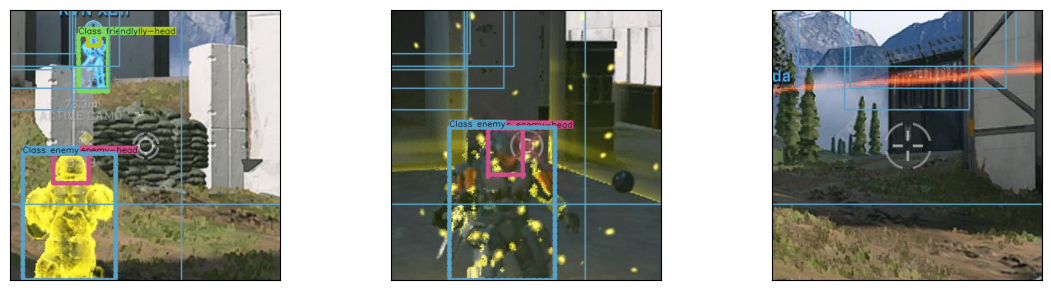

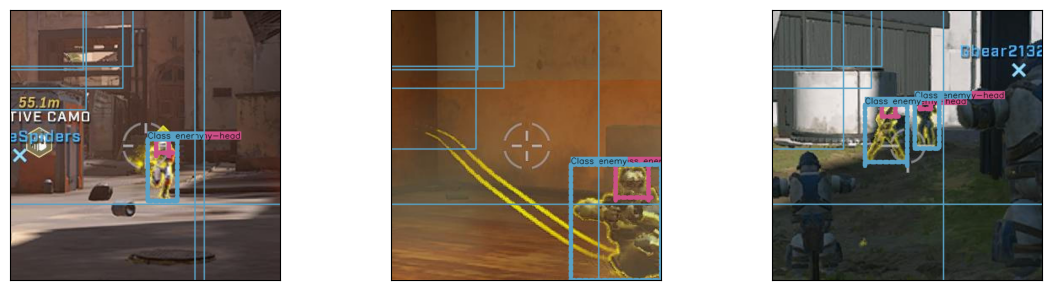

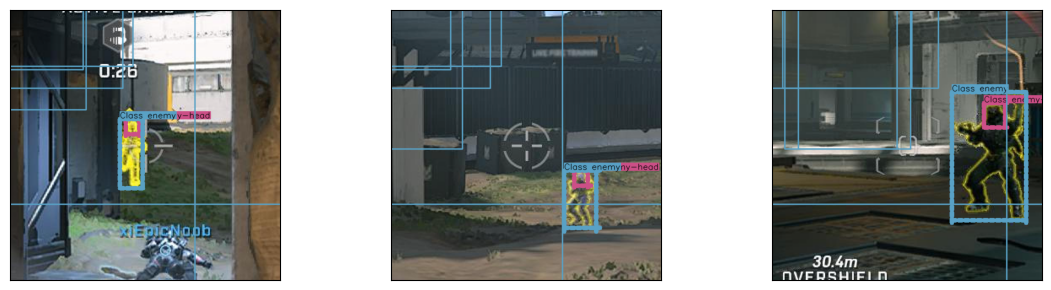

In [29]:
images, targets = next(test_iter)
preds = predict(model, images, device=device)
plot_predictions(images, preds, targets)

Ниже определена вспомогательная функция для валидации качества. Можете использовать `Runner.validate`. Важное уточнение, ей нужен метод для фильтрации предсказаний. Можете тоже скопировать его из семинара, если он у вас не менялся.

In [ ]:
from torchmetrics.detection import MeanAveragePrecision

@torch.no_grad()
def validate(dataloader, filter_predictions_func, box_format="xyxy", device="cpu", score_threshold=0.1, nms_threshold=0.5, **kwargs):
    """ Метод для валидации модели.
    Возвращает mAP (0.5 ... 0.95).
    """
    self.model.eval()
    # Считаем метрику mAP с помощью функции из torchmetrics
    metric = MeanAveragePrecision(box_format=box_format, iou_type="bbox")
    for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
        images = images.to(device)
        outputs = self.model(images)
        predicts = filter_predictions_func(outputs, score_threshold, nms_threshold, **kwargs)
        metric.update(predicts, targets)
    return metric.compute()["map"].item()
